# Set up Notebook

In [1]:
import os
#Specify whether to use CHEESEHEAD or synthtic data 
os.environ['config'] = 'CHEESEHEAD'
# os.environ['config'] = 'synthetic'

#Import setup module
from setup import* 

#If using limited cases- full case list read in through setup module
cases = pd.read_csv('../Inputs/cases_limited.csv', index_col = 'case') #dataframe of tower coordinates

## Date stuff

In [2]:
startdate = dt.datetime(2019, 6, 20, 1)
enddate = dt.datetime(2019, 10, 13, 23, 30)
dtindex = readdata('dtindex', startdate, enddate)
hh_index = np.arange(0, 24, 0.5) #half-hourly index

In [3]:
#Dataset parameters
case = 'A' #Currently using case 1 (interp, 1000m, updown, thin_plate_spline, Benoit)
towsmin = 15 #minimum number of towers

In [4]:
towplotlist = ['PFb', 'PFe', 'PFg', 'PFh', 'PFi', 'PFj', 'PFk',
       'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

In [5]:
colorlist = ["#1F4E79", "#AD403D", "xkcd:grey", "#2E75B6","#CB6D6B","#BDD7EE", "#DB9B99", "xkcd:ocean blue", "xkcd:terracotta", "xkcd:magenta", "xkcd:blue green", "xkcd:grey", "xkcd:sky blue", "xkcd:light orange",
             "xkcd:grey blue", "xkcd:dark yellow", "xkcd:pale purple", "xkcd:coral",
              "xkcd:light olive", "xkcd:reddish brown", "xkcd:dark lavender", "xkcd:forrest green", 
             "xkcd:light cyan", "xkcd:orchid", "xkcd:puke yellow", "xkcd:periwinkle blue", "#CF7B67"]

## Functions

In [6]:
#Function to mean diurnal cycle
def day_cyc(dat):
    dat_day = dat.groupby(dat.index.time).mean()
    return dat_day

# Read in/set up data 


In [7]:
#Horizontal wind
hrz_wind = readdata('hrz_wind', startdate, enddate) #Horizontal wind- includes WS_top, WD

#MO length
MO = readdata('MO', startdate, enddate)

#zeta
zeta = readdata('zeta', startdate, enddate)

#Vertical wind
w_son = readdata('w_son', startdate, enddate)
w_cont = readdata('w_cont', startdate, enddate)

#Energy budget components
E_budget = pd.read_pickle(input_filepath + 'Cons_input_data/E_budget.pickle')[startdate:enddate]

#Nans
nanmask = pd.read_pickle(intermed_filepath + 'nandat/trac_nanmask.pickle')[startdate:enddate]
nancount = pd.read_pickle(intermed_filepath + 'nandat/trac_nancount.pickle')[startdate:enddate]

#Vertical wind
w_son = readdata('w_son', startdate, enddate).apply(pd.to_numeric, errors='coerce')
w_cont = readdata('w_cont', startdate, enddate)

#Met data
TA = readdata('TA', startdate, enddate)

In [8]:
#Read in advection data
filepath = output_filepath + 'adv_final/H_hrz_all.pickle'
H_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/LE_hrz_all.pickle'
LE_hrz = pd.read_pickle(filepath)

filepath = output_filepath + 'adv_final/vert_ad_son.pickle'
vert_ad_son = pd.read_pickle(filepath).apply(pd.to_numeric, errors='coerce')

filepath = output_filepath + 'adv_final/vert_ad_cont.pickle'
vert_ad_cont = pd.read_pickle(filepath)

### Consolidate advection data

In [9]:
#Create dataframe to hold data filtered for when at least 10 towers have data
adv_nanfilt = make_multi_df([['H_hrz', 'LE_hrz', 'H_vert', 'LE_vert'], towlist], ['var', 'tow'], dtindex)

#Add each advection term  
adv_nanfilt['H_hrz'] = H_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_hrz'] = LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['H_vert'] = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
adv_nanfilt['LE_vert'] = vert_ad_son['LE'].where(nancount.max(axis = 1)<=towsmin)

### Energy residuals

In [10]:
#Energy residuals
E_res_na_all = E_budget.Rnet - E_budget.G - E_budget.H_turb - E_budget.LE_turb - E_budget.SH - E_budget.SLE  + E_budget.SG
#Need to figure out sign of SG
E_res_wa = E_res_na_all - adv_nanfilt['H_hrz'] - adv_nanfilt['LE_hrz'] - adv_nanfilt['H_vert'] - adv_nanfilt['LE_vert']
E_res_na = E_res_na_all.where(E_res_wa.notnull()) #filter only for times when E_res_wa has values

In [11]:
E_res_na_perc = E_res_na/(E_budget.Rnet + E_budget.G)
E_res_wa_perc = E_res_wa/(E_budget.Rnet + E_budget.G)

## Available Energy

In [12]:
#available energy 
AE = E_budget.Rnet - E_budget.G - E_budget.SH - E_budget.SLE  #+E_budget.SG?

## Daytime filtering

In [13]:
# lat = tc.loc

In [14]:
#Filtering for nans

In [15]:
def nanfilt(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_f = x[mask]
    y_f = y[mask]
    
    return x_f, y_f

## Bowen Ratio

In [16]:
BR_turb = E_budget.H_turb/E_budget.LE_turb
BR_adv = (adv_nanfilt.H_hrz + adv_nanfilt.H_vert)/(adv_nanfilt.LE_hrz + adv_nanfilt.LE_vert)

# Filtering

## Mask to filter for specific times

In [17]:
day_mask = (dtindex.hour > 5) & (dtindex.hour < 19) #Mask for only daytime hours
exp_day_mask = np.tile(day_mask[:, None], (1, 18)) #expanded day mask

## Filter for different conditions

In [18]:
MO.shape

(5566, 18)

In [19]:
#Different filtering variations
E_res_na_abs = E_res_na.abs()
E_res_wa_abs = E_res_wa.abs()

#Filter for unstable time steps
E_res_na_us = E_res_na.where(MO<0)
E_res_wa_us = E_res_wa.where(MO<0)

#stable
E_res_na_s = E_res_na.where(MO>0)
E_res_wa_s = E_res_wa.where(MO>0)

#Unstable, daytime, positive E_res
E_res_na_us_day_pos = E_res_na.where(MO<0).where(exp_day_mask).where(E_res_na>0)
E_res_wa_us_day_pos = E_res_wa.where(MO<0).where(exp_day_mask).where(E_res_na>0)

# #Stable, daytime, positive E_res
# E_res_na_s_day_pos = E_res_na.where(MO>0).where(exp_day_mask).where(E_res_na>0)
# E_res_wa_s_day_pos = E_res_wa.where(MO>0).where(exp_day_mask).where(E_res_na>0)



# Analysis and Plotting

## Select which data to use

In [20]:
#Actual E_res
E_res_na_use = E_res_na_us_day_pos
E_res_wa_use = E_res_wa_us_day_pos

#Absolute value of E_res
E_res_na_use_abs = E_res_na_use.abs()
E_res_wa_use_abs = E_res_wa_use.abs()

tow = 'PFb'

## Energy balance improvement calculations

In [21]:
E_bal_impr = (E_res_na_use_abs - E_res_wa_use_abs)/E_res_na_use_abs #percent improvement

#Percent of times improved, grouped by time
times_impr_time = (E_res_na_use_abs > E_res_wa_use_abs).groupby(dtindex.time).sum().sum(axis = 1)
times_worse_time = (E_res_na_use_abs < E_res_wa_use_abs).groupby(dtindex.time).sum().sum(axis = 1)
perc_times_impr_time = times_impr_time/(times_impr_time + times_worse_time)


#Percent of times improved, not grouped
times_impr = (E_res_na_use_abs > E_res_wa_use_abs).sum()
times_worse = (E_res_na_use_abs < E_res_wa_use_abs).sum()
perc_times_impr = times_impr/(times_impr + times_worse)

## Historgram of residual

In [22]:
cutoff_perc = 0.1

E_res_na_hr = E_res_na.resample('1h').mean()
E_res_wa_hr = E_res_wa.resample('1h').mean()

E_res_na_pos = E_res_na_hr.where(E_res_na>=0) #Only when residual is positive

E_res_impr = (E_res_na_pos - E_res_wa.abs())/E_res_na_pos

pos_impr = E_res_impr>cutoff_perc
neg_impr = E_res_impr<-cutoff_perc
no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)

pos_impr_count = pos_impr.groupby(pos_impr.index.hour).sum().sum(axis = 1)
neg_impr_count = neg_impr.groupby(neg_impr.index.hour).sum().sum(axis = 1)
no_impr_count = no_impr.groupby(no_impr.index.hour).sum().sum(axis = 1)

all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100
neg_impr_perc = neg_impr_count/all_impr_count*100
no_impr_perc = no_impr_count/all_impr_count*100

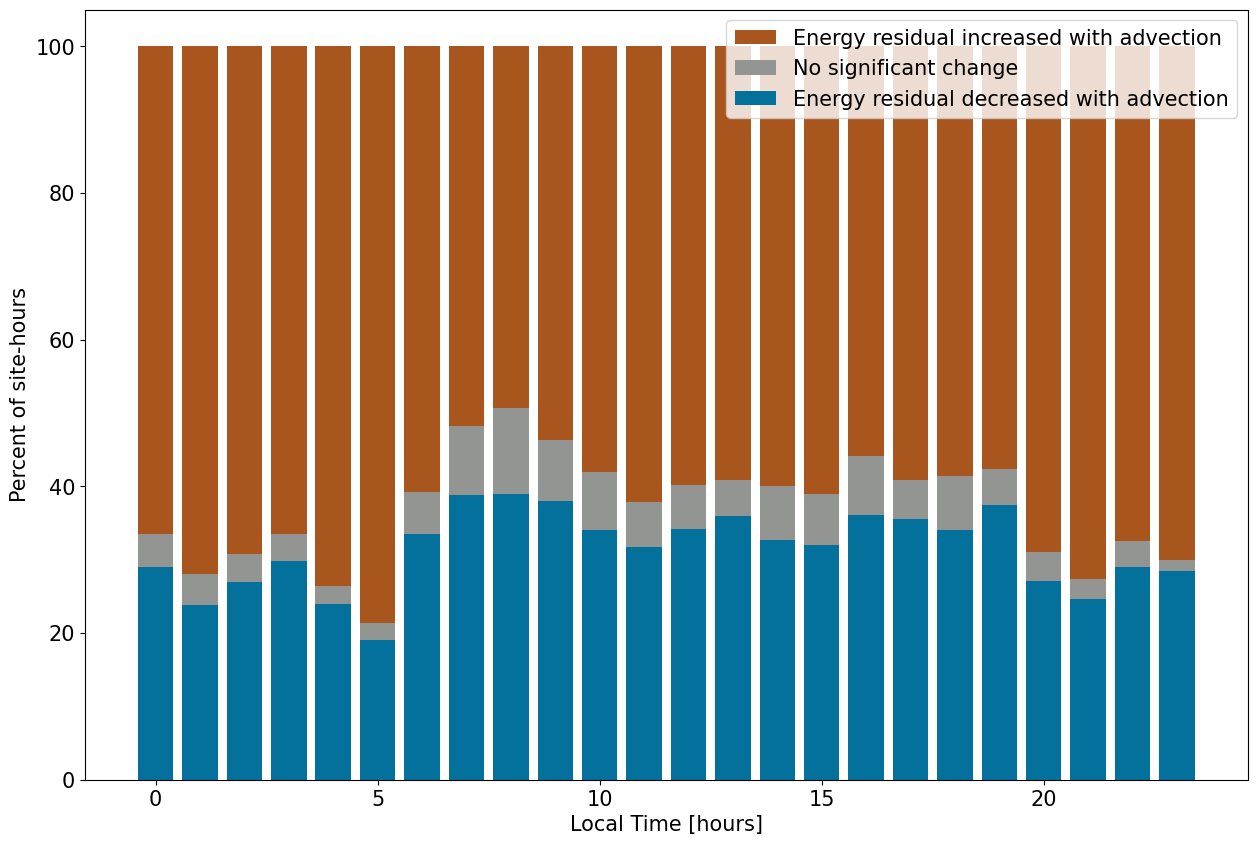

In [23]:
plt.figure(figsize=(15, 10))
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc + neg_impr_perc, color = "xkcd:sienna", 
        label = 'Energy residual increased with advection')
plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc, color = "xkcd:grey", label = 'No significant change')
plt.bar(pos_impr_perc.index, pos_impr_perc, color = "xkcd:ocean blue", label = 'Energy residual decreased with advection')
plt.legend(fontsize=15)
plt.xlabel('Local Time [hours]', fontsize=15)
plt.ylabel('Percent of site-hours', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.savefig('../../Poster_images/E_bal_impr.png')
# for hour in pos_impr_perc.index:
#     plt.annotate(str(all_impr_count.loc[hour]), (hour-0.5, 100))

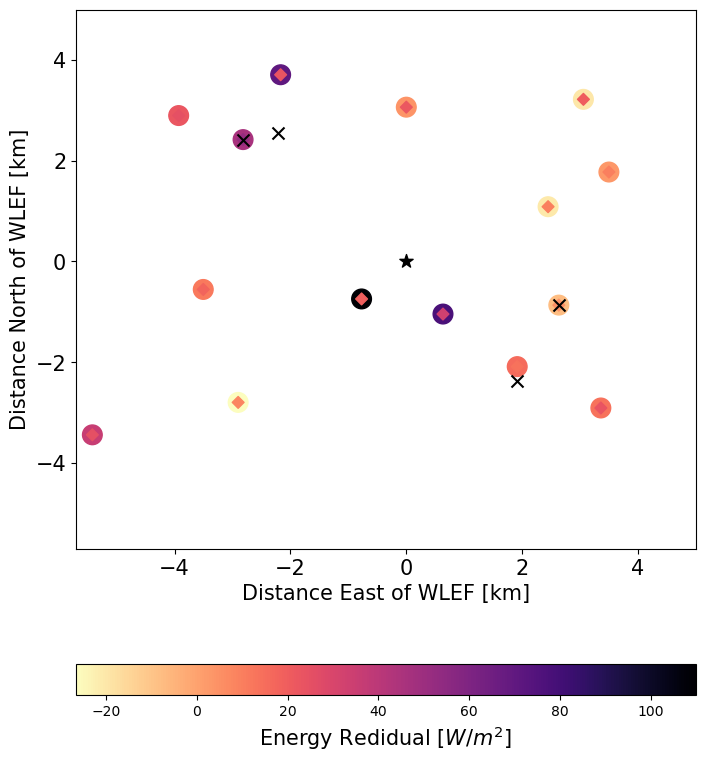

In [24]:

import matplotlib.colors as mcolors
cmap = 'magma_r'
E_res_wa_mean = E_res_wa.mean()
E_res_na_mean = E_res_na.mean()

norm = mcolors.Normalize(vmin=min(E_res_wa_mean.min(), E_res_na_mean.min()), 
                         vmax= 110)#max(E_res_wa_mean.max(), E_res_na_mean.max()))

plt.figure(figsize=(8, 10))
plt.scatter(tc.x/1000, tc.y/1000, c = E_res_wa_mean, s = 200,  cmap = cmap, norm = norm)
plt.scatter(tc.x/1000, tc.y/1000, c = E_res_na_mean, marker = 'D', cmap = cmap, norm = norm)
cbar = plt.colorbar(location = 'bottom')
plt.xlim(-5.7, 5)
plt.ylim(-5.7, 5)

plt.scatter(tc.x.loc['PFA'], tc.y.loc['PFA'], c = 'k', s = 100, marker = '*')
plt.scatter(tc.x.loc['PFc']/1000, tc.y.loc['PFc']/1000, c = 'k', s = 75, marker = 'x')
plt.scatter(tc.x.loc['PFd']/1000, tc.y.loc['PFd']/1000, c = 'k', s = 75, marker = 'x')
plt.scatter(tc.x.loc['PFr']/1000, tc.y.loc['PFr']/1000, c = 'k', s = 75, marker = 'x')
plt.scatter(tc.x.loc['PFs']/1000, tc.y.loc['PFs']/1000, c = 'k', s = 75, marker = 'x')

plt.xlabel('Distance East of WLEF [km]', fontsize = 15)
plt.ylabel('Distance North of WLEF [km]', fontsize = 15)

plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

cbar.set_label(label = 'Energy Redidual [$W/m^2$]',size=15)

plt.savefig('../../Poster_images/E_res_map.png')

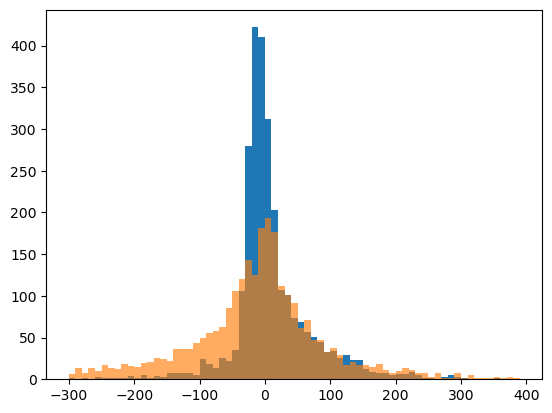

In [25]:
tow = 'PFh'
plt.hist(E_res_na[tow], np.arange(-300, 400, 10));
plt.hist(E_res_wa[tow], alpha = 0.65, bins = np.arange(-300, 400, 10));

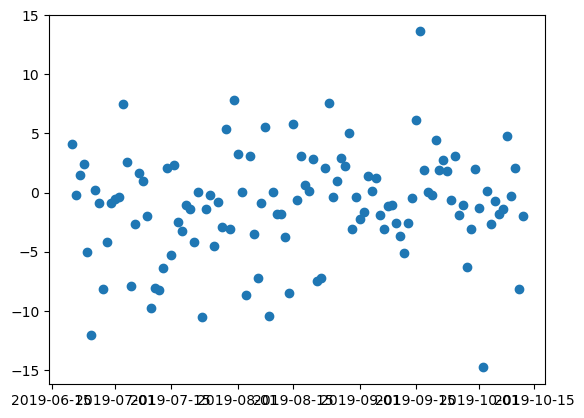

In [26]:
adv_resamp = adv_nanfilt.resample('1d').mean().mean(axis = 1)
plt.scatter(adv_resamp.index, adv_resamp)


Text(0, 0.5, 'Fraction of measurements improved')

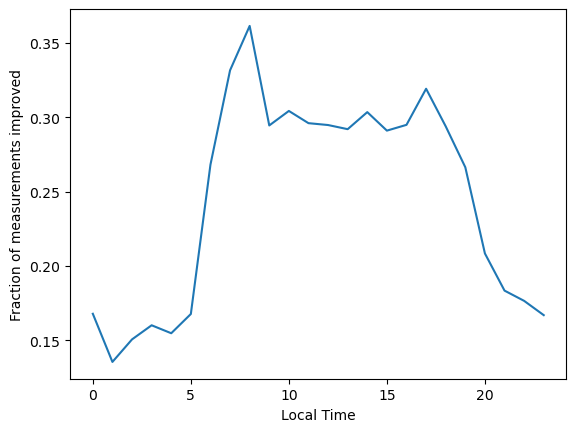

In [27]:
times_impr = (E_res_na_abs > E_res_wa_abs).groupby(E_res_na_abs.index.hour).sum().sum(axis = 1)
times_worse = (E_res_na_abs < E_res_wa_abs).groupby(E_res_na_abs.index.hour).sum().sum(axis = 1)
percent_impr_hour = times_impr/(times_impr + times_worse)
plt.plot(percent_impr_hour.values)
plt.xlabel('Local Time')
plt.ylabel('Fraction of measurements improved')

In [28]:
# times_impr = (E_res_na_abs_day > E_res_wa_abs_day).groupby(mes_num).sum().sum(axis = 1)
# times_worse = (E_res_na_abs_day < E_res_wa_abs_day).groupby(mes_num).sum().sum(axis = 1)
# percent_impr = times_impr/(times_impr + times_worse)
# plt.plot(percent_impr)
# plt.ylabel('Frac times w/ improved E bal')
# plt.xlabel('Number mesurements used')

In [29]:
tow = 'PFb'
# plt.hist2d(mes_num, E_res_na[tow], range = [[0, 100], [-400, 400]], bins = 30);

In [30]:
adv_use = adv_nanfilt
adv_total = adv_use.T.groupby(level='tow').sum(min_count=4).T
# adv_total = adv_nanfilt['H_hrz'] + adv_nanfilt['LE_hrz']

(-250.0, 300.0)

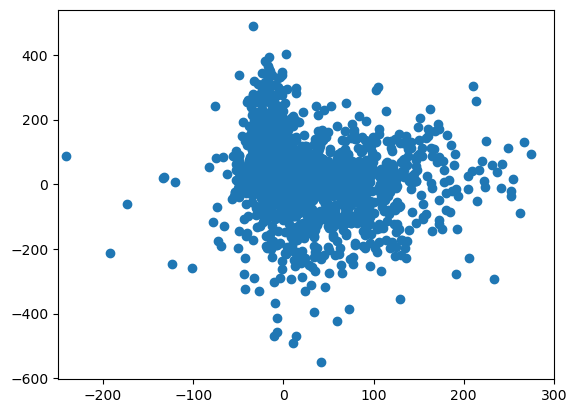

In [31]:
tow = 'PFg'
# plt.plot(E_res_na[tow].groupby(E_res_na.index.time).mean().values.cumsum());
# plt.plot(E_res_wa[tow].groupby(E_res_wa.index.time).mean().values.cumsum());

plt.scatter(E_res_na[tow], adv_total[tow]);
# plt.plot(E_res_wa[tow]);
plt.xlim(-250, 300)

In [32]:
cutend = dt.datetime(2019, 8, 29)
cutstart = cutend
cutend = cutstart + dt.timedelta(days = 3)

Text(0, 0.5, 'Advective Flux [$W/m^2$]')

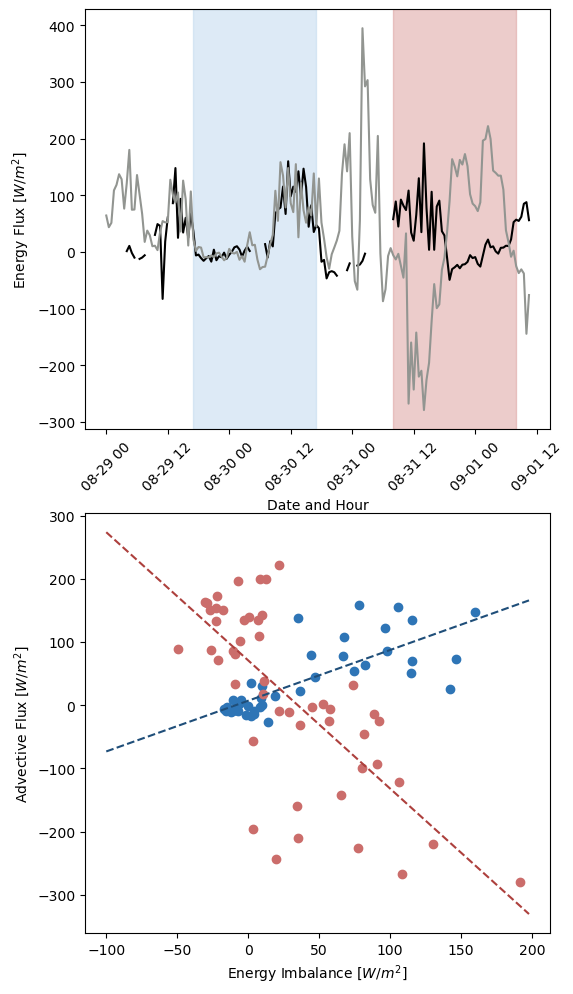

In [33]:
cutstart = dt.datetime(2019, 8, 29)
cutend = dt.datetime(2019, 9, 1, 15)

cutstart_1 = dt.datetime(2019, 8, 29, 17)
cutend_1 = dt.datetime(2019, 8, 30, 17)

cutstart_2 = dt.datetime(2019, 8, 31, 8)
cutend_2 = dt.datetime(2019, 9, 1, 8)

tow = 'PFg'

fig, ax = plt.subplots(2, 1, figsize = [6, 12])

ax[0].plot(E_res_na[tow][cutstart:cutend], c = 'k')
ax[0].plot(adv_total[tow][cutstart:cutend], c = colorlist[2])

ax[0].axvspan(cutstart_1, cutend_1, color=colorlist[5], alpha=0.5)
ax[0].axvspan(cutstart_2, cutend_2, color=colorlist[6], alpha=0.5)


ax[0].tick_params(axis='x', labelrotation=45);

ax[0].set_xlabel('Date and Hour')
ax[0].set_ylabel('Energy Flux [$W/m^2$]')

#Ax 2

ax[1].scatter(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1], c = colorlist[3])
ax[1].scatter(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2], c = colorlist[4])

regress_1 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_1:cutend_1], adv_total[tow][cutstart_1:cutend_1]))
regress_2 = scipy.stats.linregress(nanfilt(E_res_na[tow][cutstart_2:cutend_2], adv_total[tow][cutstart_2:cutend_2]))

x = np.arange(-100, 200, 2)
y_1 = regress_1[0]*x + regress_1[1]
y_2 = regress_2[0]*x + regress_2[1]

ax[1].plot(x, y_1, c = colorlist[0], linestyle = '--')
ax[1].plot(x, y_2, c = colorlist[1], linestyle = '--')
ax[1].set_xlabel('Energy Imbalance [$W/m^2$]')
ax[1].set_ylabel('Advective Flux [$W/m^2$]')
                 

LinregressResult(slope=0.0875779194018077, intercept=0.07235488616083052, rvalue=0.12091423147872125, pvalue=1.4260403362819874e-109, stderr=0.003923428487511846, intercept_stderr=0.010079984382327673)

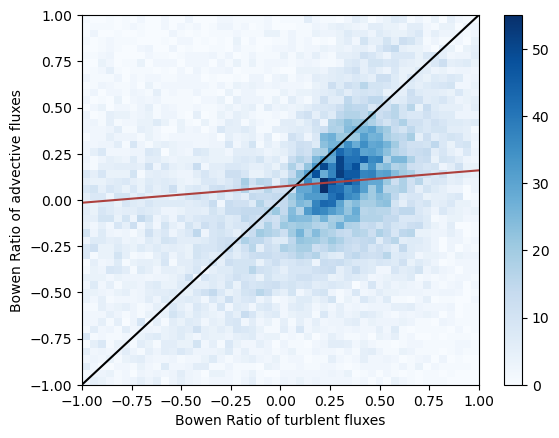

In [34]:
lim = 10
plt_lim = 1
x, y = nanfilt(BR_turb.where((BR_turb<lim) &(BR_turb >-lim)).to_numpy().flatten(), BR_adv.where((BR_adv<lim) &(BR_adv >-lim)).to_numpy().flatten())
# x, y = nanfilt(BR_turb.where((BR_turb<5) &(BR_turb >-5))[tow].to_numpy().flatten(), BR_adv.where((BR_adv<5) &(BR_adv >-5))[tow].to_numpy().flatten())
plt.hist2d(x, y, range = [[-plt_lim, plt_lim], [-plt_lim, plt_lim]], bins = 50, cmap = 'Blues');


# plt.scatter(x, y, marker = 'o', facecolors='none', edgecolors=colorlist[0], alpha = 0.2);
# plt.xlim(-plt_lim, plt_lim)
# plt.ylim(-plt_lim, plt_lim)
regress = scipy.stats.linregress(x, y)

x_11 = np.arange(-(lim+0.5), 4*lim-1.5, 2*lim-1)
plt.plot(x_11, x_11, c = 'k')
plt.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
plt.xlabel('Bowen Ratio of turblent fluxes')
plt.ylabel('Bowen Ratio of advective fluxes')
plt.colorbar()
regress

In [35]:
all_adv_towlist = ['PFb', 'PFc', 'PFe', 'PFg', 'PFh', 'PFi', 'PFj', 'PFk',
       'PFl', 'PFm', 'PFn', 'PFp', 'PFq', 'PFs', 'PFt']

regress_out = pd.DataFrame(index = all_adv_towlist, columns = ['slope', 'intercept', 'R2'])



for tow in all_adv_towlist:
    x, y = nanfilt(E_res_na[tow], adv_total[tow])
    towregress = scipy.stats.linregress(x, y)
    regress_out.loc[tow, 'slope'] = towregress[0]
    regress_out.loc[tow, 'intercept'] = towregress[1]
    regress_out.loc[tow, 'R2'] = towregress[2]**2
    
regress_out

,slope,intercept,R2
PFb,-0.28661,8.979888,0.024477
PFc,0.026916,4.329715,0.001423
PFe,-0.619094,-33.149987,0.072743
PFg,-0.211345,22.724436,0.016875
PFh,0.100736,29.689379,0.002882
PFi,-0.134983,42.607063,0.002787
PFj,-0.018643,7.479485,0.000253
PFk,0.16537,-15.603267,0.006594
PFl,0.057444,5.362383,0.000651
PFm,0.655191,29.624575,0.048657


Text(0, 0.5, 'Energy Imbalance With Advection [$W/m^2$]')

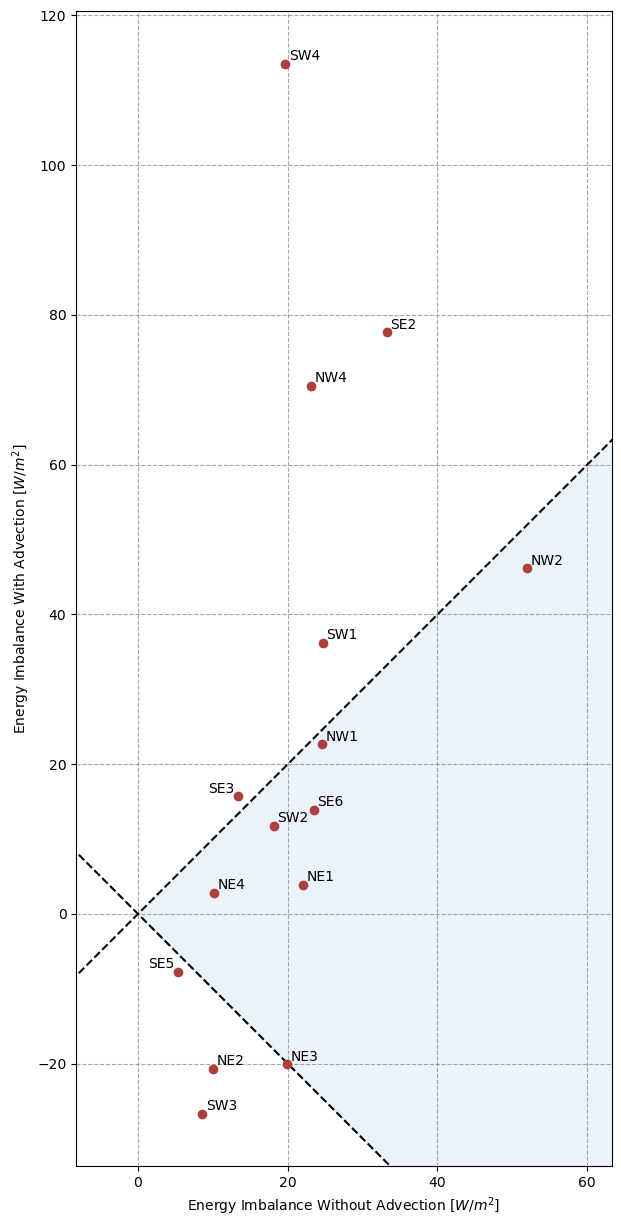

In [36]:
#Scatter plot showing imbalance before and after adcvction included

plt.figure(figsize = (8, 15))

#scatter plot of Imb without advection v. Imb with advection 
for tow in towlist:
    plt.scatter(E_res_na[tow].mean(), E_res_wa[tow].mean(), c = colorlist[1], zorder = 3)
    
    #Lable towers, need to flip side of some labels to not overlap with lines
    if tc.loc[tow].dir_names == 'SE5' or tc.loc[tow].dir_names == 'SE3':
        plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() - 4, E_res_wa[tow].mean() + 0.5), zorder = 3)
    else:
        plt.annotate(tc.loc[tow].dir_names, (E_res_na[tow].mean() + 0.5, E_res_wa[tow].mean() + 0.5), zorder = 3) 

#A couple points to just make the plot a little wider
plt.scatter(60, 50, c = 'w')
plt.scatter(-5, 50, c = 'w')


plt.xlim(-10, 70)
plt.ylim(-30, 120)

plt.axis('scaled') #Makes scale of x and y same

#plot +/- 1-1 line
x_11 = np.arange(-10, 70, 5) #values for a one-to-one line
plt.plot(x_11, x_11, c = 'k', zorder = 2, linestyle = '--')
plt.plot(x_11, -x_11, c = 'k', zorder = 2, linestyle = '--')

#Fill in area where Imb improves
plt.fill_between(np.arange(0, 90, 5), -np.arange(0, 90, 5), np.arange(0, 90, 5), color=colorlist[5], alpha=0.3, label='Improved Energy Balance', zorder = 1)

#Add grid and make xticks same as y 
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.xticks([0, 20, 40, 60]);

#Axes labels
plt.xlabel('Energy Imbalance Without Advection [$W/m^2$]')
plt.ylabel('Energy Imbalance With Advection [$W/m^2$]')

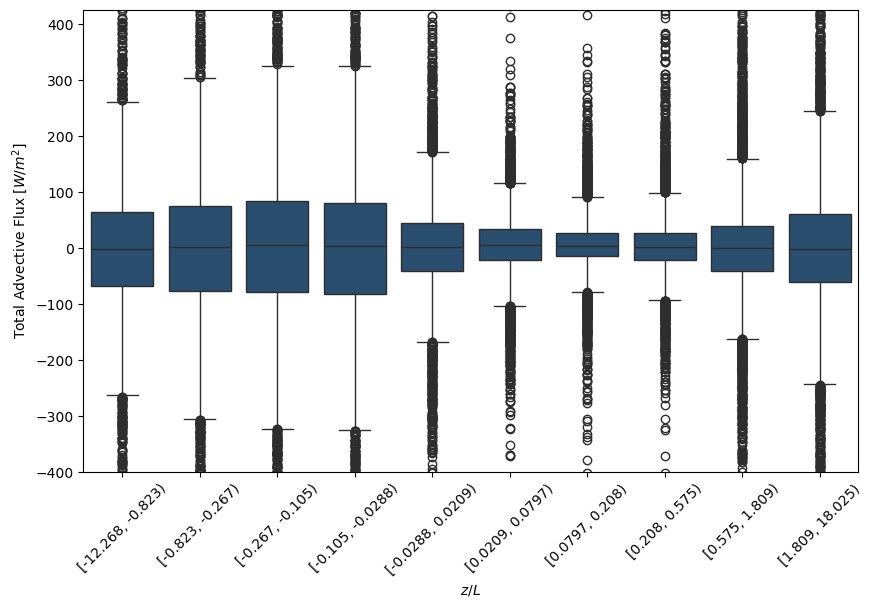

In [37]:
E_res_imp = (E_res_na.abs() - E_res_wa.abs())/E_res_na.abs()
# x = hrz_wind['WD']
x = zeta
y = adv_total


#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0.01)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(0.99))

bins_array = np.array(bins_list)


# Create bins using pd.cut(), adjusted with slight shifts to ensure inclusion
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)

# bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=np.arange(bin_min, bin_max+bin_size, bin_size), right=False)
y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')

boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)
        
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bin', y='Value', data=boxplot_df, color = colorlist[0])
# plt.boxplot(boxplot_df)
plt.xlabel('$z/L$')
plt.ylabel('Total Advective Flux [$W/m^2$]')

plt.ylim(-400, 425)
plt.xticks(rotation = 45)
plt.show()


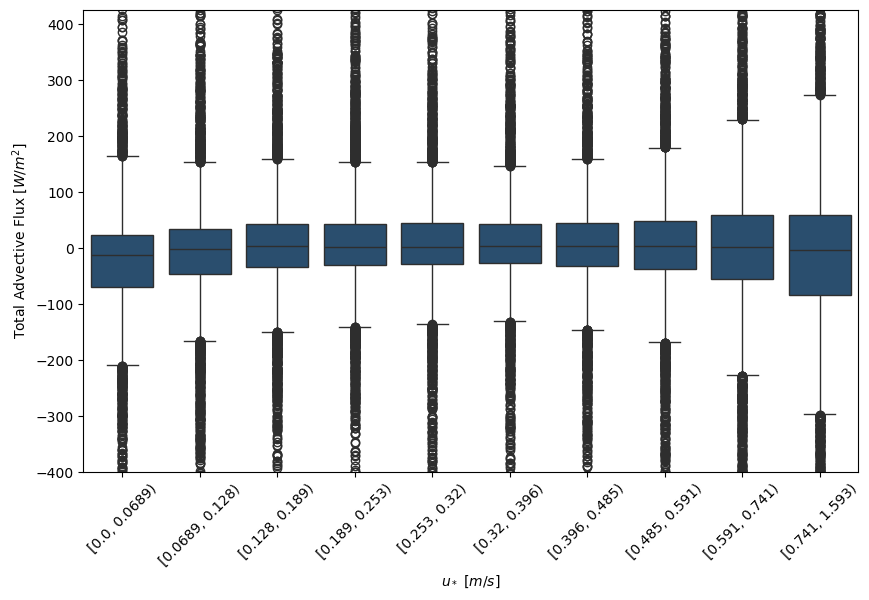

In [38]:
E_res_imp = (E_res_na.abs() - E_res_wa.abs())/E_res_na.abs()
# x = hrz_wind['WD']
x = hrz_wind['Ustar']
y = adv_total


#Find bin edges
x_lin = x.stack(future_stack=True).reset_index()[0]
bins_list = [x_lin.quantile(0)]
for i in np.arange(.1, 1, .1):
    bins_list.append(x_lin.quantile(i))
    
bins_list.append(x_lin.quantile(1))

bins_array = np.array(bins_list)



# bin_size = 5
# bin_max = 20
# bin_min = -10

# Generate bin edges, with small adjustments for inclusiveness
# bin_edges = np.arange(bin_min, bin_max + bin_size, bin_size) - 1e-5

# Create bins using pd.cut(), adjusted with slight shifts to ensure inclusion
bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=bins_array, right=False)

# bins = pd.cut(x.stack(future_stack=True).reset_index()[0], bins=np.arange(bin_min, bin_max+bin_size, bin_size), right=False)
y_lin = y.stack(future_stack=True).reset_index()[0] #1D y
y_grpd = y_lin.groupby(bins, observed = False).apply(list).reset_index(name = '0')

boxplot_data = []
for idx, row in y_grpd.iterrows():
    for value in row['0']:
        boxplot_data.append({'Bin': row[0], 'Value': value})
        
# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)
        
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bin', y='Value', data=boxplot_df, color = colorlist[0])
# plt.boxplot(boxplot_df)
plt.xlabel('$u_*$ [$m/s$]')
plt.ylabel('Total Advective Flux [$W/m^2$]')

plt.ylim(-400, 425)
plt.xticks(rotation = 45)
plt.show()


Text(0.5, 0.01, 'Date')

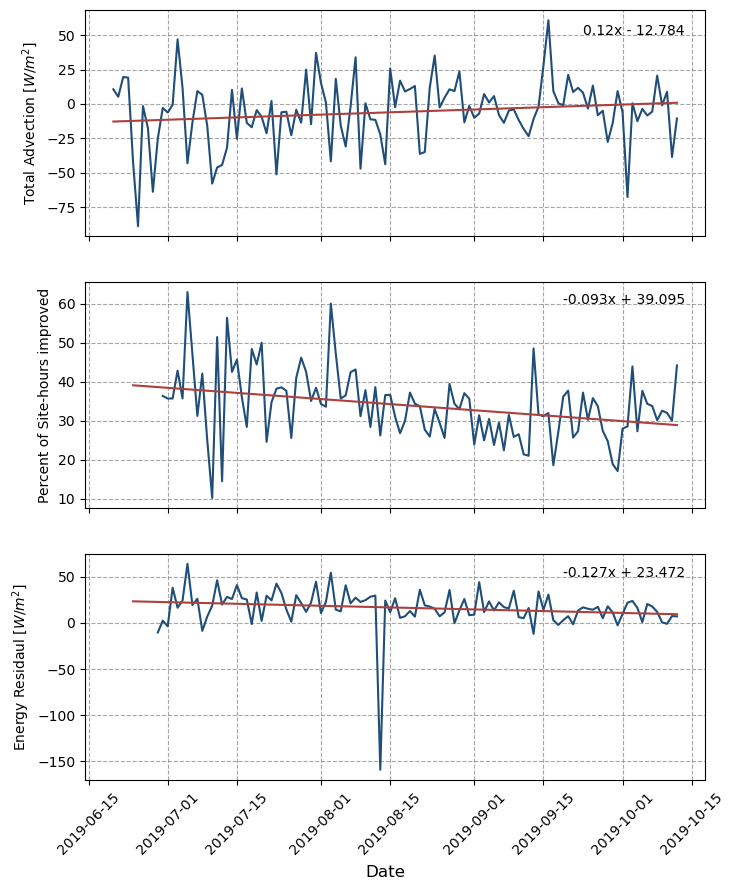

In [39]:
avg_time = '1d'


fig, axs = plt.subplots(3, 1, figsize = (8, 10), sharex = True)

'''advection'''
adv_resamp = adv_total.resample(avg_time).mean().mean(axis = 1)
axs[0].plot(adv_resamp.index, adv_resamp, c = colorlist[0])
x_dt, y = nanfilt(adv_resamp.index, adv_resamp)
x = (x_dt - x_dt[0]).days
regress = scipy.stats.linregress(x, y)
y_bf = regress[0]*x + regress[1]
axs[0].plot(x_dt, y_bf, c = colorlist[1])
axs[0].annotate(str(regress[0].round(3)) + 'x - ' + str(-regress[1].round(3)), (x_dt[-20], 50))



axs[0].set_ylabel('Total Advection [$W/m^2$]')

'''percent site-hours improved'''

cutoff_perc = 0.1

pos_impr = E_res_impr>cutoff_perc
neg_impr = E_res_impr<-cutoff_perc
no_impr = (E_res_impr<=cutoff_perc)&(E_res_impr>=-cutoff_perc)


pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
neg_impr_count = neg_impr.resample(avg_time).sum().sum(axis = 1)
no_impr_count = no_impr.resample(avg_time).sum().sum(axis = 1)
all_impr_count = pos_impr_count + neg_impr_count + no_impr_count

pos_impr_perc = pos_impr_count/all_impr_count*100
axs[1].plot(pos_impr_perc.index, pos_impr_perc, c = colorlist[0])

pos_impr_count = pos_impr.resample(avg_time).sum().sum(axis = 1)
pos_impr_perc = pos_impr_count/all_impr_count*100
x_dt, y = nanfilt(pos_impr_perc.index, pos_impr_perc)
x = (x_dt - x_dt[0]).days
regress = scipy.stats.linregress(x, y)
y_bf = regress[0]*x + regress[1]
axs[1].plot(x_dt, y_bf, c = colorlist[1])
axs[1].annotate(str(regress[0].round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-24], 60))
axs[1].set_ylabel('Percent of Site-hours improved')


E_res_resamp = E_res_na.resample(avg_time).mean().mean(axis = 1)
axs[2].plot(E_res_resamp.index, E_res_resamp, c = colorlist[0])

x_dt, y = nanfilt(E_res_resamp.index, E_res_resamp)
x = (x_dt - x_dt[0]).days
regress = scipy.stats.linregress(x, y)
y_bf = regress[0]*x + regress[1]
axs[2].plot(x_dt, y_bf, c = colorlist[1])
axs[2].annotate(str(regress[0].round(3)) + 'x + ' + str(regress[1].round(3)), (x_dt[-24], 50))
axs[2].set_ylabel('Energy Residaul [$W/m^2$]')


axs[0].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
axs[1].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
axs[2].grid(True, which='both', linestyle='--', color='gray', alpha=0.7)
plt.xticks(rotation = 45);

fig.supxlabel('Date')



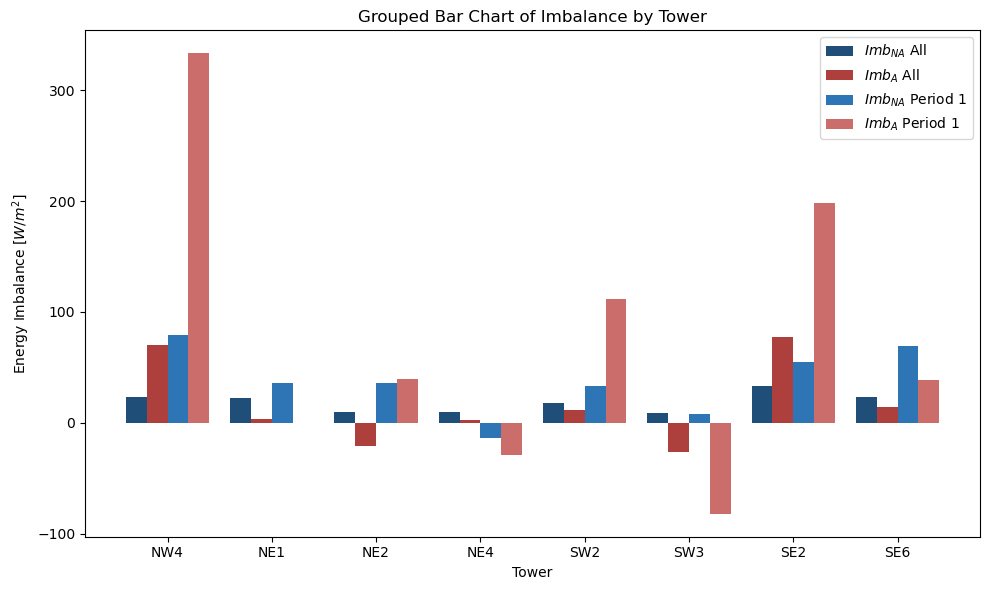

In [40]:
cut_towlist =['PFe', 'PFg', 'PFh', 'PFj', 'PFl', 'PFm', 'PFp', 'PFt'] 
cut_towlist_dir = tc.loc[cut_towlist]['dir_names']
colorlist_sub = ['#1F4E79','#AD403D','#2E75B6','#CB6D6B']

Imb_df = pd.DataFrame(index = cut_towlist, columns = ['NA_all', 'WA_all', 'NA_cut', 'WA_cut'])

for tow in cut_towlist:
    Imb_df.loc[tow, 'NA_all'] = E_res_na[tow].mean()
    Imb_df.loc[tow, 'WA_all'] = E_res_wa[tow].mean()
    Imb_df.loc[tow, 'NA_cut'] = E_res_na[cutstart_1:cutend_1][tow].mean()
    Imb_df.loc[tow, 'WA_cut'] = E_res_wa[cutstart_1:cutend_1][tow].mean()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Number of towers (rows) and number of columns
towers = Imb_df.index
columns = Imb_df.columns
n_towers = len(towers)
n_columns = len(columns)

# Define the width of each bar and create an array for bar positions
bar_width = 0.2
indices = np.arange(n_towers)
labellist = ['$Imb_{NA}$ All', '$Imb_A$ All', '$Imb_{NA}$ Period 1', '$Imb_A$ Period 1']

# Plot each column as a separate bar
for i, col in enumerate(columns):
    ax.bar(indices + i * bar_width, Imb_df[col], width=bar_width, label=labellist[i], color = colorlist_sub[i])

# Set labels, title, and x-ticks
ax.set_xlabel('Tower')
ax.set_ylabel('Energy Imbalance [$W/m^2$]')
ax.set_title('Grouped Bar Chart of Imbalance by Tower')
ax.set_xticks(indices + bar_width * (n_columns - 1) / 2)  # Center x-ticks
ax.set_xticklabels(cut_towlist_dir)

# Add a legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
# for i in range(len(cut_towlist)):
#     tow = cut_towlist[i]
#     plt.scatter(E_res_na[cutstart_1:cutend_1][tow], adv_total[cutstart_1:cutend_1][tow], marker = '.', color = colorlist_sub[i], label = tc.loc[tow]['dir_names'])
#     plt.legend()
    
# plt.xlabel('Energy Imbalance [$W/m^2$]')
# plt.ylabel('Advective Flux [$W/m^2$]')

Text(-3.5, 3, '$R^2$ = 0.428')

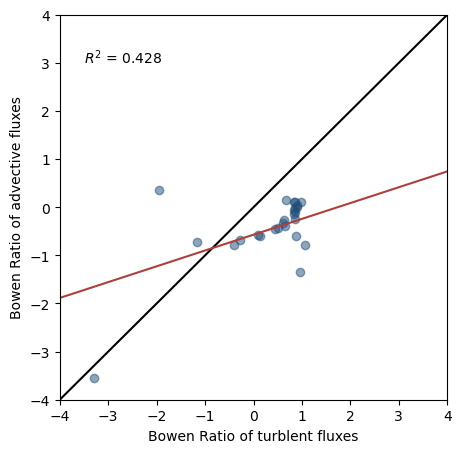

In [41]:
tow = 'PFg'

fig, ax = plt.subplots(1, figsize = (5, 5))

lim = 10 #Lim for Br used in regression
plt_lim = 4 #Lim for plotting

BR_turb_cut = BR_turb[cutstart_1:cutend_1][tow]
BR_adv_cut = BR_adv[cutstart_1:cutend_1][tow]
x, y = nanfilt(BR_turb_cut.where((BR_turb_cut<lim) & (BR_turb_cut>-lim)).to_numpy().flatten(), BR_adv_cut.where((BR_adv_cut<lim) &(BR_adv_cut >-lim)).to_numpy().flatten())
# x, y = nanfilt(BR_turb_cut.to_numpy().flatten(), BR_adv_cut.to_numpy().flatten())


ax.scatter(x, y, c = colorlist[0], alpha = 0.5)
ax.set_xlim(-plt_lim, plt_lim)
ax.set_ylim(-plt_lim, plt_lim)


regress = scipy.stats.linregress(x, y)
plt_lim = 10

x_11 = np.arange(0.5-plt_lim, 3*plt_lim-1.5, 2*plt_lim-1)
ax.plot(x_11, x_11, c = 'k')
ax.plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax.set_xlabel('Bowen Ratio of turblent fluxes')
ax.set_ylabel('Bowen Ratio of advective fluxes')

ax.annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-3.5, 3))




H R2:  0.15165612649336543
LE R2:  0.0007183311138428086


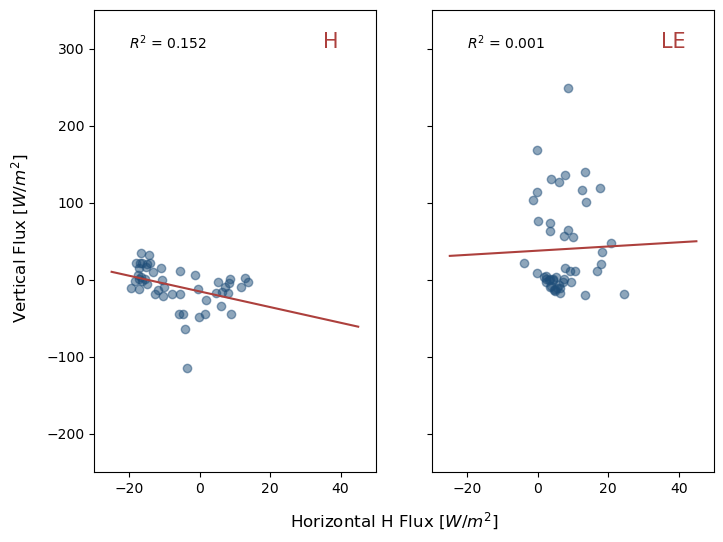

In [42]:
'''Hrz v vert advective fluxes'''

x_11 = np.arange(-25, 50, 70)

fig, ax = plt.subplots(1, 2, figsize = [8, 6], sharex = True, sharey = True)

adv_cut = adv_nanfilt[cutstart_1:cutend_1]

#Horizontal Fluxes
x, y = nanfilt(adv_cut.H_hrz[tow].to_numpy().flatten(), adv_cut.H_vert[tow].to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[0].scatter(x, y, c=colorlist[0], alpha = 0.5);
ax[0].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[0].annotate('H', (35, 300), size = 15, c = colorlist[1])
print('H R2: ', regress[2]**2)
ax[0].annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-20, 300))

#Vertical Fluxes
x, y = nanfilt(adv_cut.LE_hrz[tow].to_numpy().flatten(), adv_cut.LE_vert[tow].to_numpy().flatten())
regress = scipy.stats.linregress(x, y)
ax[1].scatter(x, y, c=colorlist[0], alpha = 0.5);
ax[1].plot(x_11, regress[0]*x_11 + regress[1], c = colorlist[1])
ax[1].annotate('LE', (35, 300), size = 15, c = colorlist[1])
ax[1].annotate('$R^2$ = ' + str((regress[2]**2).round(3)), (-20, 300))

plt.xlim(-30, 50)
plt.ylim(-250, 350)


fig.supxlabel('Horizontal H Flux [$W/m^2$]')
fig.supylabel('Vertical Flux [$W/m^2$]')

plt.savefig('../../Thesis_materials/hrx_v_vert_adv.png')
print('LE R2: ', regress[2]**2)


# plt.savefig('../../Thesis_materials/BR_turb_adv_CS1.png')



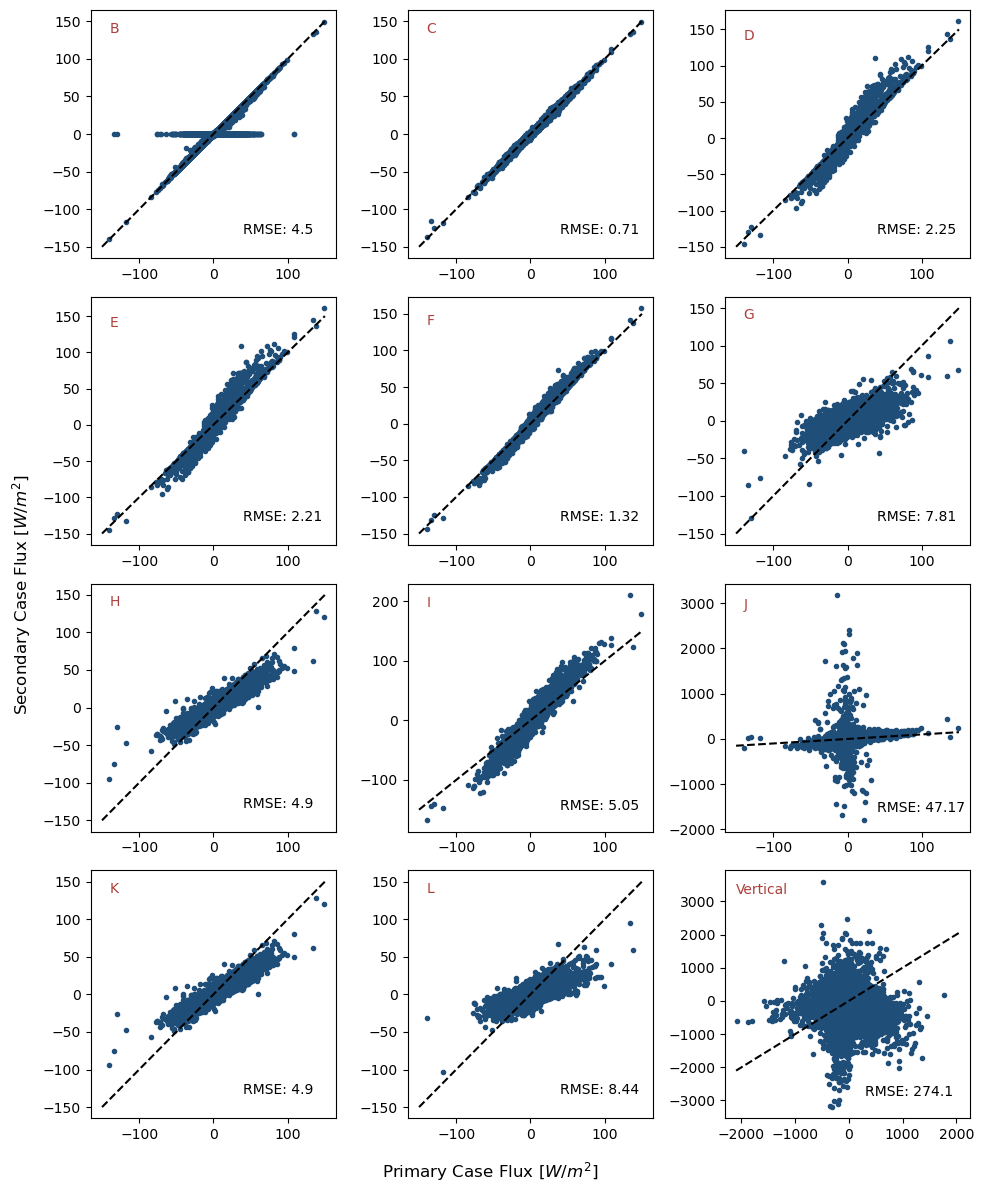

In [43]:
hrz_tot_A = H_hrz['A'].where(nancount.max(axis = 1)<=towsmin) + LE_hrz['A'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_son = vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_son['H'].where(nancount.max(axis = 1)<=towsmin)
vert_tot_cont = vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin) + vert_ad_cont['H'].where(nancount.max(axis = 1)<=towsmin)

fig, axs = plt.subplots(4, 3, figsize = (10, 12))
RMSE = pd.DataFrame(index = cases.index[1:], columns = ['RMSE'])

for i in range(len(cases.index[1:])):
    case = cases.index[i+1]
    ax = axs[i//3, i%3]
    hrz_tot = H_hrz[case].where(nancount.max(axis = 1)<=towsmin) + LE_hrz[case].where(nancount.max(axis = 1)<=towsmin)
    ax.scatter(hrz_tot_A, hrz_tot, marker = '.', c = colorlist[0])
    RMSE_case  = (((hrz_tot_A - hrz_tot)**2).mean().mean())**(1/2)
    RMSE.loc[case, 'RMSE'] = RMSE_case 
    
    if case == 'I' or case == 'J':
        ax.annotate(case, (-140, hrz_tot.max().max()*0.9), fontsize = 10, c = colorlist[1])
        ax.annotate('RMSE: ' + str(round(RMSE_case, 2)), (40, hrz_tot.min().min()*0.9), fontsize = 10)
    else:
        ax.annotate(case, (-140, 135), fontsize = 10, c = colorlist[1])
        ax.annotate('RMSE: ' + str(round(RMSE_case, 2)), (40, -133), fontsize = 10)
    x11 = np.arange(-150, 200, 50)
    ax.plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)
    
    
axs[3, 2].scatter(vert_tot_son, vert_tot_cont, marker = '.', c = colorlist[0])
RMSE_case  = (((vert_tot_son - vert_tot_cont)**2).mean().mean())**(1/2)
axs[3, 2].annotate('RMSE: ' + str(round(RMSE_case, 1)), (300, vert_tot_cont.min().min()*0.9), fontsize = 10)
axs[3, 2].annotate('Vertical', (-2100, vert_tot_cont.max().max()*0.9), fontsize = 10, c = colorlist[1])
x11 = np.arange(-2100, 2100, 50)
axs[3, 2].plot(x11, x11, c = 'k', linestyle = '--', zorder = 1)

fig.supxlabel('Primary Case Flux [$W/m^2$]')
fig.supylabel('Secondary Case Flux [$W/m^2$]')

plt.tight_layout()

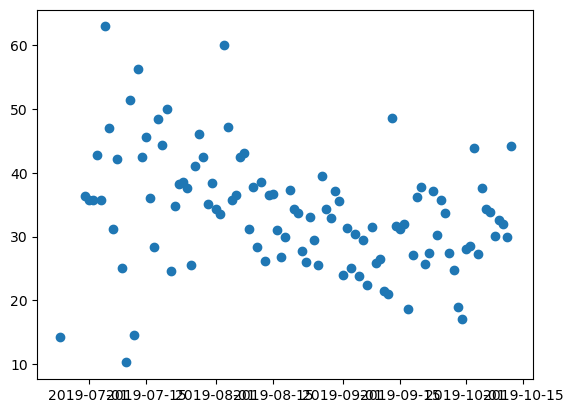

In [44]:


plt.scatter(pos_impr_perc.index, pos_impr_perc)

# plt.figure(figsize=(15, 10))
# plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc + neg_impr_perc, color = "xkcd:sienna", 
#         label = 'Energy residual increased with advection')
# plt.bar(pos_impr_perc.index, pos_impr_perc + no_impr_perc, color = "xkcd:grey", label = 'No significant change')
# plt.bar(pos_impr_perc.index, pos_impr_perc, color = "xkcd:ocean blue", label = 'Energy residual decreased with advection')
# plt.legend(fontsize=15)
# plt.xlabel('Local Time [hours]', fontsize=15)
# plt.ylabel('Percent of site-hours', fontsize=15)
# plt.xticks(fontsize=15);
# plt.yticks(fontsize=15);

# plt.savefig('../../Poster_images/E_bal_impr.png')
# # for hour in pos_impr_perc.index:
# #     plt.annotate(str(all_impr_count.loc[hour]), (hour-0.5, 100))

# Plotting Templates

In [45]:
# #Map of tower locations and Ebal improvement
# plt.scatter(tc.x, tc.y, c = perc_times_impr)
# plt.colorbar(label = 'Fraction of times with improved energy balance')

In [46]:
# #Percent improvement 
# times_impr = (E_res_na_use_abs > E_res_wa_use_abs).groupby(mes_num).sum().sum(axis = 1)
# times_worse = (E_res_na_use_abs < E_res_wa_use_abs).groupby(mes_num).sum().sum(axis = 1)
# percent_impr = times_impr/(times_impr + times_worse)

# #Scatter plot and best fit line

# percent_impr_or = percent_impr.dropna()#.drop([61, 77, 89]) #percent_impr with outliers removed
# x = percent_impr_or.index
# y = percent_impr_or
# plt.scatter(x, y)

# bf_line = scipy.stats.linregress(x, y)

# plt.plot(x, bf_line[0]*x + bf_line[1], c = 'r')

# plt.xlabel('number of measurements used')
# plt.ylabel('fraction of times with improved energy balance')

In [47]:
# #Scatter plots of anomolies with tower labels
# TA_anom = TA[2].sub(TA[2].mean(axis = 1), axis = 0)
# w_son_anom = w_son.sub(w_son.mean(axis = 1), axis = 0)
# w_cont_anom = w_cont.sub(w_son.mean(axis = 1), axis = 0)



# for tow in towlist:
#     plt.annotate(tow, (w_son_anom.mean()[tow], TA_anom.mean()[tow]))
#     #Might be interesting to combine this with w_cont_anom

# plt.xlim(-.06, .1)
# plt.ylim(-.35, .65)

# plt.ylabel('Temporal mean of spatial anomoly of 2m temperature')
# plt.xlabel('Temporal mean of spatial anomoly of vertical velocity')
# plt.title('w from sonic')

In [48]:
# #Plot diurnal averages
# # towplotlist = ['PFb','PFg', 'PFh', 'PFi', 'PFj', 'PFk',
# #        'PFl', 'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

# towplotlist = towlist

# fig, axs = plt.subplots(6, 3, figsize = [15, 8], sharex=True, sharey=True)
# for i in range(len(towplotlist)):
    
#     tow = towplotlist[i]
        
#     #select axis    
#     ax = axs[i//3, i%3]
    
#     #plot cumulative energy residual with and 
#     a = ax.plot(hh_index, np.cumsum(day_cyc(E_res_na[tow]).values)*60*30/10e3, color = 'olivedrab', label = 'without advective fluxes')
#     b = ax.plot(hh_index, np.cumsum(day_cyc(E_res_wa[tow]).values)*60*30/10e3, color = 'coral', label = 'with advective fluxes')
    
#     ax.set_title(towplotlist[i])
#     if i == 0:
#         fig.legend()
        
# fig.supxlabel('Hour of day in local time')
# fig.supylabel('Average Energy Residual [$kJ/m^2$]')
# plt.tight_layout()
# # fig.legend([a, b], labels = ['Cumulative Energy Balance Without Hrz Advection', 'Cumulative Energy Balance With Hrz Advection'], loc="upper right")

# # fig.savefig('../Outputs/Plots/CumulativeEbal_case' + str(case) + '.png')

In [49]:
# #Plot diurnal averages
# towplotlist = ['PFb','PFg', 'PFh', 'PFi', 'PFj', 'PFk',
#        'PFl', 'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

# # towplotlist = towlist

# fig, axs = plt.subplots(4, 3, figsize = [8, 8], sharex=True, sharey=True)
# for i in range(len(towplotlist)):
    
#     tow = towplotlist[i]
        
#     #select axis    
#     ax = axs[i//3, i%3]
    
#     #plot cumulative energy residual with and 
#     a = ax.hist(E_res_na_us[tow], color = 'olivedrab', label = 'without advective fluxes', bins = 20, density = True)
#     b = ax.hist(E_res_wa_us[tow], color = 'coral', label = 'with advective fluxes', alpha = 0.5, 
#                 density = True, bins = 20)
    
#     ax.set_title(towplotlist[i])
#     if i == 0:
#         fig.legend()
        
# fig.supxlabel('Energy balance residual [$W/m^2$')
# # fig.supylabel('Normalized Frequency')
# # plt.tight_layout()
# # fig.legend([a, b], labels = ['Cumulative Energy Balance Without Hrz Advection', 'Cumulative Energy Balance With Hrz Advection'], loc="upper right")

# # fig.savefig('../Outputs/Plots/CumulativeEbal_case' + str(case) + '.png')

In [50]:
# #Plot diurnal averages

# case = 'average'
# LE_use = LE_hrz[11]
# H_use = H_hrz[11]
# vert_use = vert_ad_son

# # time_ind = hrz_ad.loc['H'].groupby(hrz_ad.loc['H'].index.time).mean().index

# towplotlist = ['PFb','PFg', 'PFh', 'PFi', 'PFj', 'PFk',
#        'PFl', 'PFm', 'PFn', 'PFp', 'PFq', 'PFt']

# fig, axs = plt.subplots(4, 3, figsize = [13, 8], sharex=True, sharey=True)
# for i in range(len(towplotlist)):
#         tow = towplotlist[i]
        
#         filepath = tc.org_path.loc[tow]
#         df = pd.read_csv(filepath)

#         df = df.map(lambda x: np.nan if x == -9999 else x)

#         dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
#         df.set_index(dt_ts, inplace = True)

#         #start and end date set at top of notebook
#         df = df[startdate:enddate]

#         NETRAD = df.NETRAD_1_1_1
#         LE_turb = df.LE_1_1_1
#         H_turb = df.H_1_1_1
#         G = df.G_1_1_1

#         LE_ad_hrz = LE_use[tow]#.loc[startdate:enddate]
#         H_ad_hrz = H_use[tow]#.loc[startdate:enddate]
        
#         LE_ad_vert = vert_use['LE', tow]
#         H_ad_vert = vert_use['H', tow]


#         E_bal_ad = NETRAD - LE_turb - H_turb - G - LE_ad_hrz - H_ad_hrz - LE_ad_vert - H_ad_vert - LE_ad_vert - H_ad_vert
#         E_bal_no_ad = NETRAD - LE_turb - H_turb - G
#         E_bal_imp = np.abs(E_bal_no_ad) - np.abs(E_bal_ad) #Energy balance improvement
        
#         WD = df.WD_1_1_1
#         WD_range = np.arange(0, 360+10, 10)
#         ax = axs[i//3, i%3]
#         # a = ax.plot(WD_range[0:-1], E_bal_imp.groupby(pd.cut(WD, WD_range), observed = True).sum())
#         # a = ax.plot(WD_range[0:-1], E_bal_ad.groupby(pd.cut(WD, WD_range), observed = True).mean())
#         # b = ax.plot(WD_range[0:-1], E_bal_no_ad.groupby(pd.cut(WD, WD_range), observed = True).mean())
#         # ax.hist(E_bal_imp, bins = 30)
        
#         a = ax.plot(hh_index, np.cumsum(day_cyc(E_bal_no_ad).values)*60*30/10e3, color = 'olivedrab', label = 'without advective fluxes')
#         b = ax.plot(hh_index, np.cumsum(day_cyc(E_bal_ad).values)*60*30/10e3, color = 'coral', label = 'with advective fluxes')
        
#         # a = ax.plot(time_ind, day_cyc(E_bal_no_ad), color = 'olivedrab', label = 'no adv')
#         # b = ax.plot(time_ind, day_cyc(E_bal_ad), color = 'coral', label = 'with adv')
#         # b = ax.plot(time_ind, day_cyc(LE_ad_hrz), color = 'olivedrab', label = 'LE hrz')
#         # c = ax.plot(time_ind, day_cyc(H_ad_hrz), color = 'olivedrab', label = 'H hrz')
#         # d = ax.plot(time_ind, day_cyc(LE_ad_hrz), color = 'olivedrab', label = 'LE hrz')
#         # e = ax.plot(time_ind, day_cyc(LE_ad_hrz), color = 'olivedrab', label = 'LE hrz')
        
        
#         ax.set_title(towplotlist[i])
#         if i == 0:
#             fig.legend()
        
# fig.supxlabel('Hour of day in local time')
# fig.supylabel('Average Cumulative Diurnal Energy Imbalance [$kJ/m^2$]')
# # plt.tight_layout()
# # fig.legend([a, b], labels = ['Cumulative Energy Balance Without Hrz Advection', 'Cumulative Energy Balance With Hrz Advection'], loc="upper right")

# # fig.savefig('../Outputs/Plots/CumulativeEbal_case' + str(case) + '.png')

# Archive

In [51]:
# mes_num = 18*6 - nancount.sum(axis = 1)

In [52]:
# # calculate mean of all cases
# H_tot = 0
# LE_tot = 0
# for case in cases.index:
#     H_tot = H_tot + H_hrz[case]
#     LE_tot = LE_tot + LE_hrz[case]
    

    
# H_hrz_avg = H_tot/len(cases.index)
# LE_hrz_avg = LE_tot/len(cases.index)

In [53]:
##Ebal improvement box plots
# fig, axs = plt.subplots(4, 3, figsize = [10, 10])
# for i in range(len(towplotlist)):
#     tow = towplotlist[i]
#     ax = axs[i//3, i%3]             
#     datause = Ebal_imp_all[tow]
#     ax.boxplot(datause[np.isfinite(datause.astype(float))])
#     # ax.hist(datause)

## Vert wind

In [54]:
# #Plot vertical wind from sonic and continuity v. hrz wind direction
# fig, axs = plt.subplots(6, 3, figsize = [13, 13])#, sharex=True, sharey=True)
# for i in range(len(towlist)):
#         tow = towlist[i]
        
#         ax = axs[i//3, i%3]

#         ax.scatter(hrz_wind['WD'][tow], w_son[tow], s = 1.5)
#         ax.scatter(hrz_wind['WD'][tow], w_cont[tow], s = 1.5)
        
#         # a = ax.plot(time_ind, np.cumsum(day_cyc(E_bal_no_ad).values)*60*30/10e3, color = 'olivedrab')
#         # b = ax.plot(time_ind, np.cumsum(day_cyc(E_bal_ad).values)*60*30/10e3, color = 'coral')
        

#         ax.set_title(towlist[i])



        # ax.plot(hh_index, E_res_na[tow].groupby(E_res_na.index.time).min(), color = 'olivedrab', 
        #         linestyle = 'dashed', alpha = 0.5)
        # ax.plot(hh_index, E_res_na[tow].groupby(E_res_na.index.time).max(), color = 'olivedrab', 
        #         linestyle = 'dashed', alpha = 0.5)
        # ax.plot(hh_index, E_res_wa[tow].groupby(E_res_wa.index.time).min(), color = 'coral', 
        #         linestyle = 'dashed', alpha = 0.5)
        # ax.plot(hh_index, E_res_wa[tow].groupby(E_res_wa.index.time).max(), color = 'coral', 
        #         linestyle = 'dashed', alpha = 0.5)
        
# fig.supylabel('w')
# fig.supxlabel('Wind direction [degrees]')
# plt.tight_layout()